---
# VisionSpace Challenge
---
### Description
This Notebook includes all solutions and explainations of all three challenges.
### Requierements
The following cell installs all packages that I used to solve the tasks.
*TODO: Explain the packages*




In [6]:
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install tensorflow 
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.data import *

# Challenge I
---
## Desciption
The Janus satellite provides information that supports ground exploration missions on Mars. A sample
of the dataset in .csv format and a short description of its columns can be found in this repository:
https://github.com/visionspacetec/ai-interview-challanges
Your goal is to apply Machine Learning techniques to predict Janus’ power consumption.
## Solution
Assumption: As the exact predition goal is not further specified, I set it to a next-hour prediction, this also aligns well with real-time monitoring needs and can be helpful to determine anomalies. Another possibility would be to predict the next 24-hour profile which would be useful for battery planning or solar panel alignment. I decided against this goal as the data set includes only around 20 days and therefore such a prediciton would be really challenging because there might be long-term trends or periodic variations that are not captured by the data.

In [35]:
current_dir_path = os.getcwd()
data_file_path = os.path.join(current_dir_path, 'SatelliteDataSet.csv')

df = pd.read_csv(data_file_path)

features = ["power", "sa", "sx", "sy", "sz", "sunmars_km", 
            "earthmars_km", "sunmarsearthangle_deg", 
            "solarconstantmars", "eclipseduration_min", 
            "occultationduration_min", "flagcomms"]

#All features
#features = ["power", "sa", "sx", "sy", "sz", "sunmars_km", 
#            "earthmars_km", "sunmarsearthangle_deg", 
#            "solarconstantmars", "eclipseduration_min", 
#            "occultationduration_min", "flagcomms", 
#            "ACROSS_TRACK", "D1PVMC", "D4PNPO", "EARTH", "INERTIAL",
#            "MAINTENANCE", "NADIR", "RADIO_SCIENCE", "SLEW", "WARMUP"]

target = "power"

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [36]:
data_values = df[features].values

sequence_lenght = 5

x, y = create_sequences(data_values, target_column=features.index(target), sequence_length=sequence_lenght)

train_val_split = 0.8

train_size = int(len(x)*train_val_split)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [37]:
stop_training = EarlyStopping(monitor='val_loss', patience=20)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),# TODO check parameters
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(x_train, y_train, epochs=500, batch_size=16, validation_data=(x_test, y_test), 
                    callbacks=[stop_training], 
                    verbose=1)

Epoch 1/500


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0941 - mae: 0.2444 - val_loss: 0.0565 - val_mae: 0.1944
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454 - mae: 0.1719 - val_loss: 0.0555 - val_mae: 0.1938
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0415 - mae: 0.1675 - val_loss: 0.0559 - val_mae: 0.1938
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0391 - mae: 0.1602 - val_loss: 0.0550 - val_mae: 0.1930
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 - mae: 0.1706 - val_loss: 0.0509 - val_mae: 0.1904
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387 - mae: 0.1641 - val_loss: 0.0520 - val_mae: 0.1904
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - mae: 0.1604 - val_loss: 0.0512 - val_mae: 0.1899
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0376 - mae: 0.1615 - val_loss: 0.0479 - val_mae: 0.1886
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0428 - mae: 0.

In [41]:
# Baseline
power_values = df[['power']].values
power_values_scaled = scaler.fit_transform(power_values)

y_baseline = power_values_scaled[(sequence_lenght-1):]

y_train_baseline, y_test_baseline = y_baseline[:train_size], y_baseline[train_size:-1]


baseline_model = Sequential([
    Flatten(input_shape=(x_train.shape[1], x_train.shape[2])), # TODO:Check flatten
    Dense(1)
])

baseline_model.compile(optimizer="adam", loss='mse', metrics=["mae"])

baseline_history = baseline_model.fit(x_train, y_train_baseline,
                                      epochs=250, batch_size=16,
                                      validation_data=(x_test, y_test_baseline),
                                      callbacks=[stop_training],  verbose=1)


Epoch 1/500


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1163 - mae: 0.2727 - val_loss: 0.1092 - val_mae: 0.2618
Epoch 2/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0782 - mae: 0.2166 - val_loss: 0.0650 - val_mae: 0.1952
Epoch 3/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524 - mae: 0.1812 - val_loss: 0.0531 - val_mae: 0.1841
Epoch 4/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434 - mae: 0.1664 - val_loss: 0.0531 - val_mae: 0.1879
Epoch 5/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381 - mae: 0.1562 - val_loss: 0.0438 - val_mae: 0.1687
Epoch 6/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 - mae: 0.1402 - val_loss: 0.0431 - val_mae: 0.1705
Epoch 7/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - mae: 0.1437 - val_loss: 0.0371 - val_mae: 0.1568
Epoch 8/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - mae: 0.1279 - val_loss: 0.0354 - val_mae: 0.1546
Epoch 9/500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - mae: 0.1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


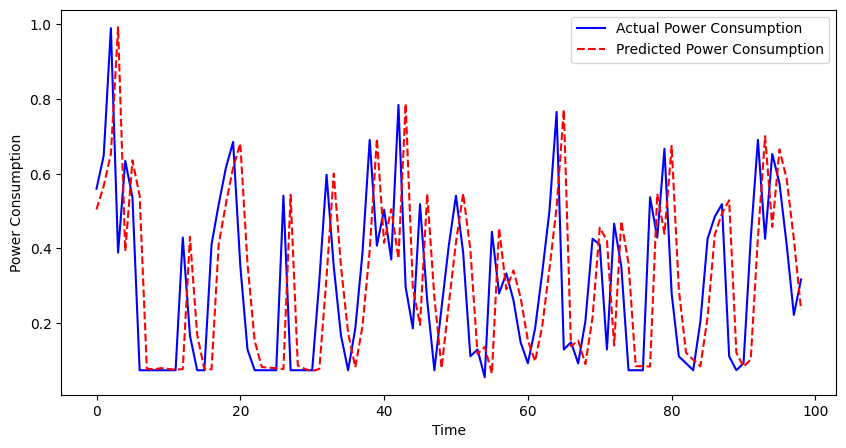

In [48]:
y_baseline_pred = baseline_model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]

plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled, label="Actual Power Consumption", color="blue")
plt.plot(y_baseline_pred_rescaled, label="Predicted Power Consumption", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

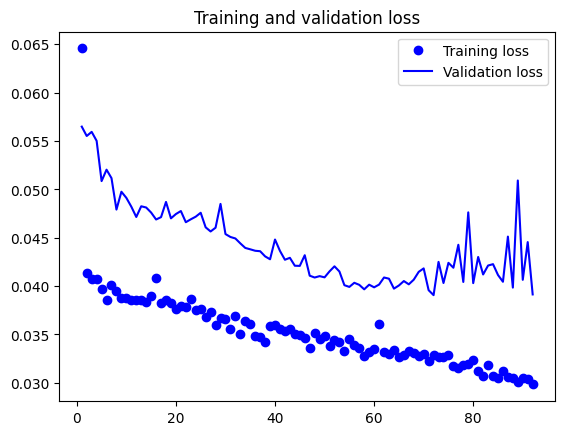

In [38]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
#mean_absolute_error = history.history['val_mae']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#plt.plot(epochs, mean_absolute_error, '--', label='Mean absolute error')

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


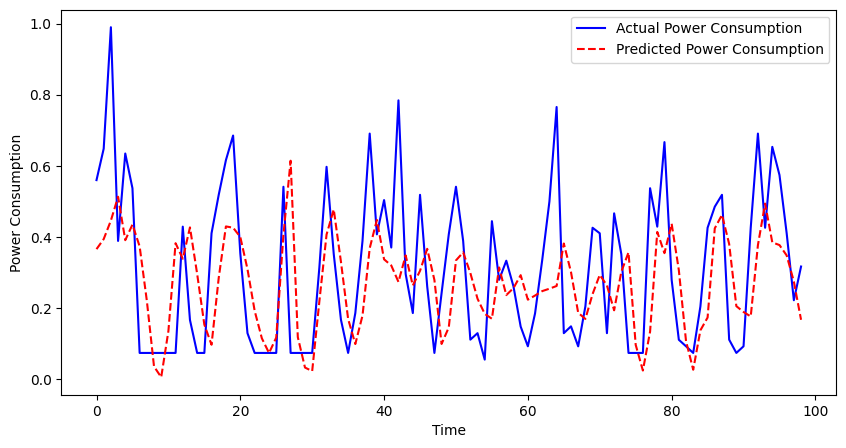

In [ ]:
y_pred = model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]

plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled, label="Actual Power Consumption", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Power Consumption", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

In [49]:
# Performance comparision

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

mae_baseline = mean_absolute_error(y_test_rescaled, y_baseline_pred_rescaled)
rmse_baseline = np.sqrt(mean_squared_error(y_test_rescaled, y_baseline_pred_rescaled))

print(f"LSTM Model: MAE = {mae_lstm:.4f}, RMSE = {rmse_lstm:.4f}")
print(f"Baseline Model: MAE = {mae_baseline:.4f}, RMSE = {rmse_baseline:.4f}")

mae_improvement = (mae_baseline - mae_lstm) / mae_baseline * 100
rmse_improvement = (rmse_baseline - rmse_lstm) / rmse_baseline * 100

print(f"MAE improvement: {mae_improvement:.2f} %")
print(f"RMSE improvement: {rmse_improvement:.2f} %")

#plt.figure(figsize=(12, 6))
#
#plt.plot(y_test_rescaled, label="Actual Power Consumption", color="blue")
#plt.plot(y_pred_rescaled, label="LSTM Prediction", color="green", linestyle="dashed")
#plt.plot(y_baseline_pred_rescaled, label="Baseline Prediction", color="red", linestyle="dotted")
#
#plt.xlabel("Time Steps")
#plt.ylabel("Power Consumption")
#plt.title("Comparison of LSTM and Baseline Predictions")
#plt.legend()
#plt.show()

LSTM Model: MAE = 0.1586, RMSE = 0.1978
Baseline Model: MAE = 0.1749, RMSE = 0.2287
MAE improvement: 9.34 %
RMSE improvement: 13.48 %
